In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
import scipy.stats
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score

from pycaret.classification import setup, compare_models, evaluate_model, plot_model
import optuna

C:\Users\Anes3\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Combine train and test data and split features/target

In [4]:
data0 = pd.concat([train_data.iloc[:, :-1], test_data]).reset_index(drop=True)
target = train_data['Transported']

In [5]:
data0.shape

(12970, 13)

In [6]:
data0.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines


In [7]:
data0.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,12700.000000,12707.000000,12681.000000,12664.000000,12686.000000,12702.000000
mean,28.771969,222.897852,451.961675,174.906033,308.476904,306.789482
std,14.387261,647.596664,1584.370747,590.558690,1130.279641,1180.097223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,49.000000,77.000000,29.000000,57.000000,42.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [8]:
data0.isnull().sum()

PassengerId       0
HomePlanet      288
CryoSleep       310
Cabin           299
Destination     274
Age             270
VIP             296
RoomService     263
FoodCourt       289
ShoppingMall    306
Spa             284
VRDeck          268
Name            294
dtype: int64

In [9]:
data1 = data0.copy()

# Feature Engineering

In [10]:
data1['GroupId'] = data1['PassengerId'].apply(lambda x: x.split('_')[0])
#data1['GroupNum'] = data1['PassengerId'].apply(lambda x: x.split('_')[1])
data1['Deck'] = data1.Cabin.apply(lambda x: str(x).split('/')[0] if x is not np.nan else x)
#data1['Num'] = data1.Cabin.apply(lambda x: str(x).split('/')[1] if x is not np.nan else x)
data1['Side'] = data1.Cabin.apply(lambda x: str(x).split('/')[2] if x is not np.nan else x)

data1 = data1.drop(['PassengerId', 'Cabin'], axis=1)

In [11]:
data2 = data1.copy()

# Categorical data cleaning

### Let's drop the name column for now

In [12]:
data2 = data2.drop('Name', axis=1)

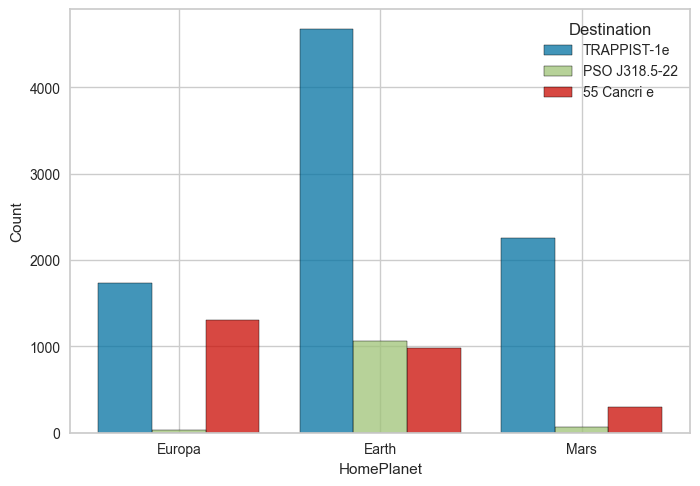

In [13]:
sns.histplot(x=data2.HomePlanet, hue=data2.Destination, multiple="dodge", shrink=.8)
plt.show()

In [14]:
CrosstabResult = pd.crosstab(index=data2['HomePlanet'],columns=data2['GroupId'])
#print(CrosstabResult)

ChiSqResult = scipy.stats.chi2_contingency(CrosstabResult)
print('\nThe P-Value of the ChiSq Test is:', ChiSqResult[1])


The P-Value of the ChiSq Test is: 2.636191617019482e-243


<AxesSubplot:xlabel='Age', ylabel='Count'>

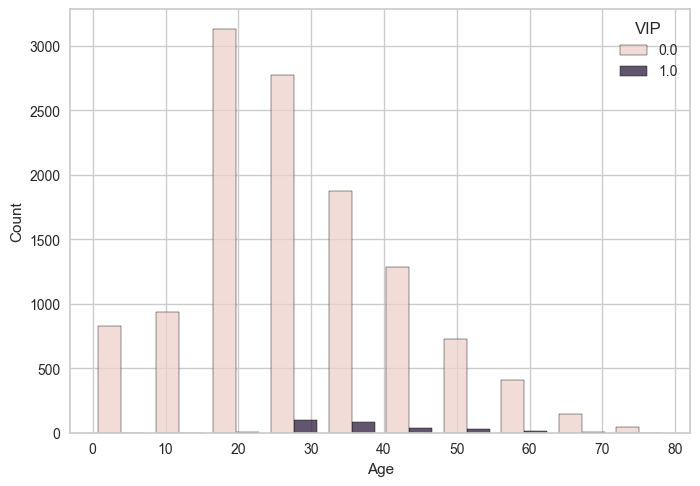

In [15]:
sns.histplot(x=data2.Age, hue=data2.VIP, multiple="dodge", shrink=.8, bins=10)

In [16]:
#Assuming the most of people in a group are often family members then same home planet and destination
data2['HomePlanet'] = data2.groupby(['GroupId'], sort=False)['HomePlanet'].apply(lambda x: x.ffill().bfill())
data2['Destination'] = data2.groupby(['GroupId'], sort=False)['Destination'].apply(lambda x: x.ffill().bfill())
#How would you shop and spend money on luxury if you're in a cryosleep?
data2.CryoSleep.loc[(data2.FoodCourt>0) | (data2.RoomService>0) | (data2.ShoppingMall>0) | (data2.Spa>0) | (data2.VRDeck>0)] = False

categorical_columns = [col for col in data2.columns if data2[col].dtypes=='object']
categorical_imputer = SimpleImputer(strategy='most_frequent')
data2[categorical_columns] = pd.DataFrame(categorical_imputer.fit_transform(data2[categorical_columns]))

In [17]:
data3 = data2.copy()

# Numerical data cleaning

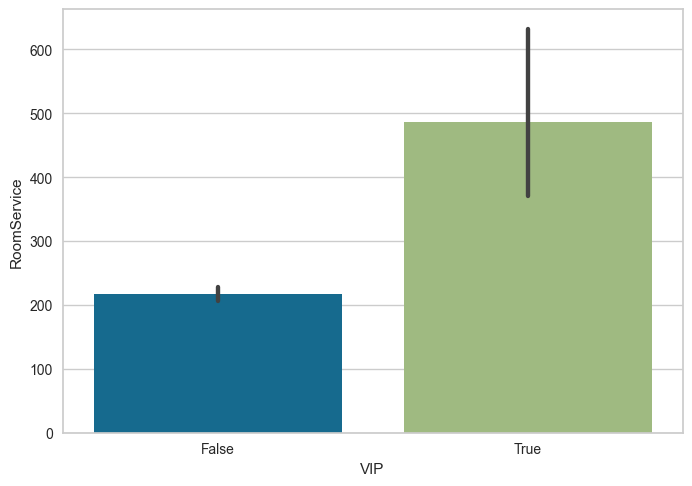

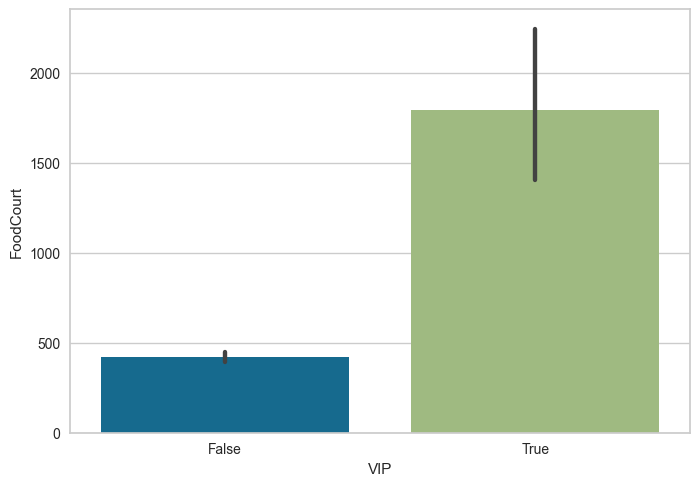

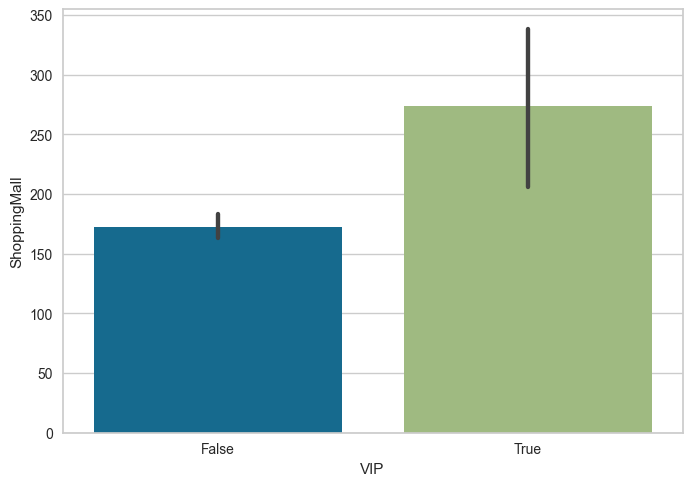

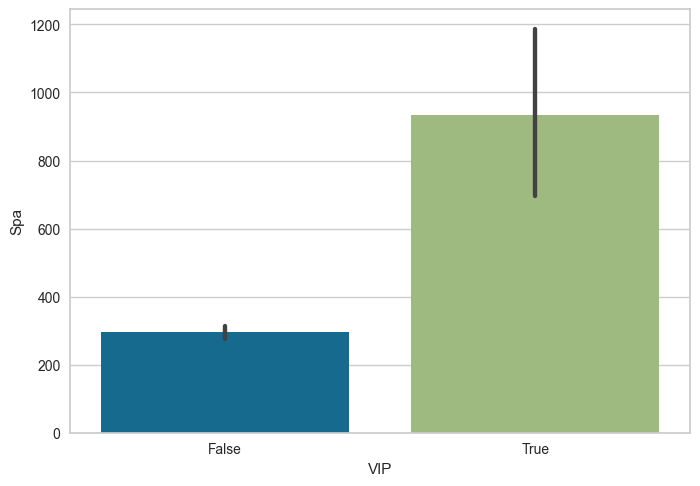

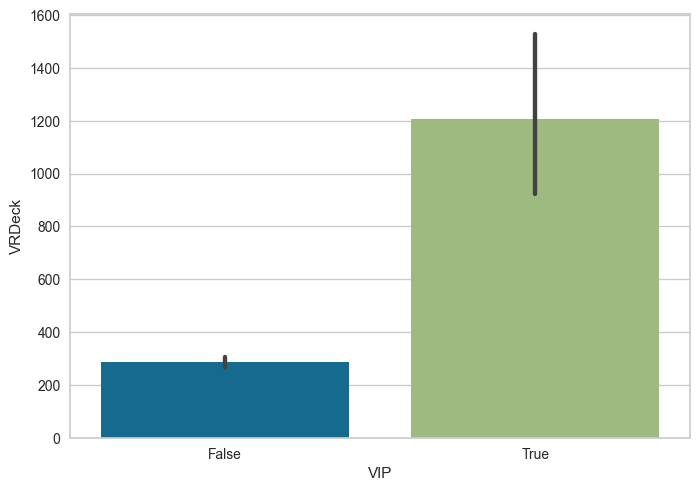

In [18]:
for col in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
    sns.barplot(x=data3['VIP'], y=data3[col])
    plt.show()

In [19]:
numerical_columns = [col for col in data3.columns if data3[col].dtypes=='float64']

for col in data3[numerical_columns]:
    if col!='Age':
        #If cryosleep then no money spent
        data3[col].loc[data3['CryoSleep']==True] = data3[col].loc[data3['CryoSleep']==True].fillna(0)
        #If not cryosleep then it median of either VIP or not VIP
        data3[col].loc[(data3['CryoSleep']==False) & (data3['VIP']==True)] = data3[col].loc[(data3['CryoSleep']==False) & (data3['VIP']==True)].fillna(data3[col].loc[(data3['CryoSleep']==False) & (data3['VIP']==True)].median())
        data3[col].loc[(data3['CryoSleep']==False) & (data3['VIP']==False)] = data3[col].loc[(data3['CryoSleep']==False) & (data3['VIP']==False)].fillna(data3[col].loc[(data3['CryoSleep']==False) & (data3['VIP']==False)].median())

numeric_df = data3.select_dtypes(np.number)
non_na_columns = numeric_df.loc[: ,numeric_df.isna().sum() == 0].columns

#Use KNN for age
y_train = numeric_df.loc[numeric_df['Age'].isna() == False, 'Age']
X_train = numeric_df.loc[numeric_df['Age'].isna() == False, non_na_columns]
X_test = numeric_df.loc[numeric_df['Age'].isna() == True, non_na_columns]

knn = KNeighborsRegressor()
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

data3.loc[data3['Age'].isna() == True, 'Age'] = y_pred

In [20]:
data3.isnull().sum()

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
GroupId         0
Deck            0
Side            0
dtype: int64

In [21]:
data4 = data3.copy()

# Feature Transformation

### Update categorical_columns

In [22]:
categorical_columns = [col for col in data4.columns if data4[col].dtypes=='object' and col!='GroupId']

for col in data4[categorical_columns]:
    dummies = pd.get_dummies(data4[col], prefix=col, drop_first=True)
    data4 = pd.concat([data4, dummies], axis=1)
    data4 = data4.drop([col], axis=1)

In [23]:
skew_cols = []
for col in data4[numerical_columns]:
    if scipy.stats.skew(data4[col])>=5:
        print(col, 'skewness:', scipy.stats.skew(data4[col]))
        skew_cols.append(col)

RoomService skewness: 6.200813957564028
FoodCourt skewness: 7.130542574957275
ShoppingMall skewness: 11.12622598927254
Spa skewness: 7.736501979602736
VRDeck skewness: 8.142427726419768


In [24]:
data4 = data4.drop('GroupId', axis=1)

In [25]:
data5 = data4.copy()

# Feature Scaling

In [26]:
scaler = StandardScaler()

scaler.fit(data5)
data5 = pd.DataFrame(scaler.transform(data5), index=data5.index, columns=data5.columns)

In [27]:
data6 = data5.copy()

# Target Transformation

In [28]:
num_target = target.astype(int)

# Split back to train and test datasets

In [29]:
train_final = data6.iloc[:8692+1, :]
test_final = data6.iloc[8692+1:, :].reset_index(drop=True)

# Based Model

In [30]:
rf = RandomForestClassifier(n_estimators=100, random_state=0)

results = []

kf = KFold(n_splits=10)

r = cross_val_score(rf, train_final, num_target, scoring='accuracy')
results.append(r)
print(f'Accuracy: {np.mean(results).round(2)}')

Accuracy: 0.79


# Compare Models

In [31]:
_ = setup(data=pd.concat([train_final, num_target], axis=1), target='Transported', numeric_features=train_final.columns.to_list())

,Description,Value
0,session_id,791
1,Target,Transported
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(8693, 21)"
5,Missing Values,False
6,Numeric Features,20
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [32]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8090,0.8921,0.8245,0.8009,0.8124,0.6180,0.6186,0.0600
gbc,Gradient Boosting Classifier,0.8051,0.8915,0.8461,0.7831,0.8132,0.6101,0.6125,0.1000
lr,Logistic Regression,0.7975,0.8828,0.8084,0.7926,0.8001,0.5950,0.5957,0.3420
ada,Ada Boost Classifier,0.7970,0.8793,0.8206,0.7850,0.8021,0.5940,0.5951,0.0410
rf,Random Forest Classifier,0.7947,0.8713,0.7636,0.8156,0.7885,0.5896,0.5911,0.2030
et,Extra Trees Classifier,0.7849,0.8469,0.7469,0.8096,0.7766,0.5699,0.5720,0.1930
svm,SVM - Linear Kernel,0.7798,0.0000,0.7747,0.7842,0.7780,0.5596,0.5616,0.0080
ridge,Ridge Classifier,0.7770,0.0000,0.7145,0.8185,0.7625,0.5542,0.5592,0.0040
lda,Linear Discriminant Analysis,0.7768,0.8613,0.7141,0.8184,0.7623,0.5539,0.5589,0.0060
knn,K Neighbors Classifier,0.7691,0.8463,0.7688,0.7712,0.7696,0.5382,0.5388,0.0660


In [33]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

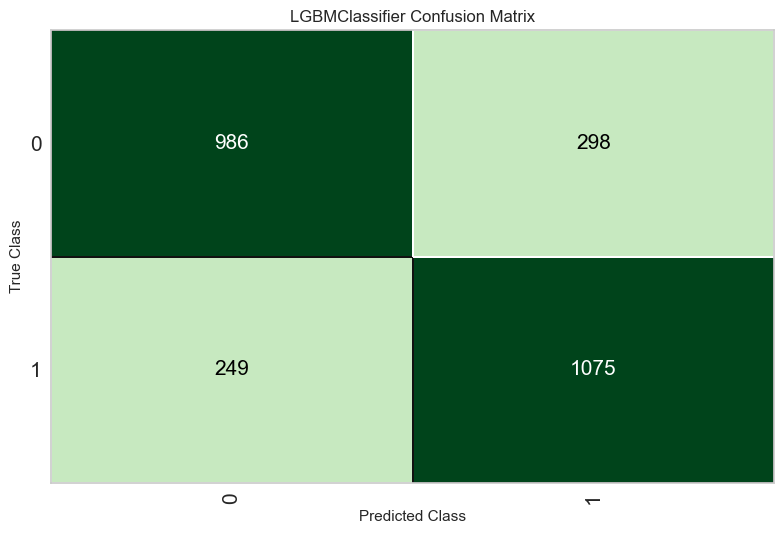

In [34]:
plot_model(best, plot = 'confusion_matrix')

In [35]:
def lightgbm(trial):
    num_leaves  = trial.suggest_int('num_leaves', 5, 100)
    max_depth = trial.suggest_int('max_depth', 1, 50)
    learning_rate = trial.suggest_loguniform('learning_rate', .001, 1)
    n_estimators = trial.suggest_int('n_estimators', 10, 500)
    min_child_samples = trial.suggest_int('min_child_samples', 1, 100)
          
    model = LGBMClassifier(
        num_leaves=num_leaves ,
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        min_child_samples=min_child_samples
    )
    
    model.fit(train_final, num_target)
    
    cv_scores = cross_val_score(model, train_final, num_target, scoring='accuracy', cv=kf)
    
    return np.mean(cv_scores)

In [36]:
def gbc(trial):
    #tol = trial.suggest_loguniform('tol', 1e-8, 10.0)
    max_depth = trial.suggest_int('max_depth', 1, 50)
    learning_rate = trial.suggest_loguniform('learning_rate', .001, 1)
    n_estimators = trial.suggest_int('n_estimators', 10, 500)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 100)
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 100)
          
    model = GradientBoostingClassifier(
        #tol=tol,
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        min_samples_leaf=min_samples_leaf,
        max_leaf_nodes=max_leaf_nodes
    )
    
    model.fit(train_final, num_target)
    
    cv_scores = cross_val_score(model, train_final, num_target, scoring='accuracy', cv=kf)
    
    return np.mean(cv_scores)

In [37]:
def lr(trial):
    tol = trial.suggest_loguniform('tol', 1e-8, 10.0)
    max_iter = trial.suggest_int('max_iter', 5, 500)
          
    model = LogisticRegression(
        tol=tol,
        max_iter = max_iter,
        solver='liblinear'
    )
    
    model.fit(train_final, num_target)
    
    cv_scores = cross_val_score(model, train_final, num_target, scoring='accuracy', cv=kf)
    
    return np.mean(cv_scores)

In [38]:
def ada(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', .001, 1)
    n_estimators = trial.suggest_int('n_estimators', 10, 500)
          
    model = AdaBoostClassifier(
        learning_rate=learning_rate,
        n_estimators=n_estimators
    )
    
    model.fit(train_final, num_target)
    
    cv_scores = cross_val_score(model, train_final, num_target, scoring='accuracy', cv=kf)
    
    return np.mean(cv_scores)

In [39]:
def rf(trial):
    max_depth = trial.suggest_int('max_depth', 1, 100)
    n_estimators = trial.suggest_int('n_estimators', 10, 500)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 100)
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 100)
          
    model = RandomForestClassifier(
        max_depth=max_depth,
        n_estimators=n_estimators,
        min_samples_leaf=min_samples_leaf,
        max_leaf_nodes=max_leaf_nodes
    )
    
    model.fit(train_final, num_target)
    
    cv_scores = cross_val_score(model, train_final, num_target, scoring='accuracy', cv=kf)
    
    return np.mean(cv_scores)

In [40]:
# study = optuna.create_study(direction='maximize')
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# study.optimize(lightgbm, n_trials=100)
# study.best_params

[I 2023-02-06 09:21:54,539] A new study created in memory with name: no-name-112655a3-544a-44af-b615-b42a6630d08f


{'num_leaves': 15,
 'max_depth': 21,
 'learning_rate': 0.03587905325565621,
 'n_estimators': 187,
 'min_child_samples': 62}

In [41]:
# study = optuna.create_study(direction='maximize')
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# study.optimize(gbc, n_trials=100)
# study.best_params

{'max_depth': 28,
 'learning_rate': 0.018232665393120646,
 'n_estimators': 425,
 'min_samples_leaf': 36,
 'max_leaf_nodes': 12}

In [42]:
# study = optuna.create_study(direction='maximize')
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# study.optimize(lr, n_trials=100)
# study.best_params

{'tol': 5.063260994083119e-05, 'max_iter': 5}

In [43]:
# study = optuna.create_study(direction='maximize')
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# study.optimize(ada, n_trials=100)
# study.best_params

{'learning_rate': 0.6788563392087933, 'n_estimators': 217}

In [44]:
# study = optuna.create_study(direction='maximize')
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# study.optimize(rf, n_trials=100)
# study.best_params

{'max_depth': 70,
 'n_estimators': 57,
 'min_samples_leaf': 6,
 'max_leaf_nodes': 94}

In [45]:
lightgbm_params = {
    'num_leaves': 15,
    'max_depth': 48,
    'learning_rate': 0.026299056229909256,
    'n_estimators': 353,
    'min_child_samples': 64
}

gbc_params = {
    'max_depth': 28,
    'learning_rate': 0.018232665393120646,
    'n_estimators': 425,
    'min_samples_leaf': 36,
    'max_leaf_nodes': 12
}

lr_params = {
    'solver': 'liblinear',
    'tol': 5.063260994083119e-05, 
    'max_iter': 5
}

ada_params = {
    'learning_rate': 0.6788563392087933, 
    'n_estimators': 217
}

rf_params = {
    'max_depth': 70,
    'n_estimators': 57,
    'min_samples_leaf': 6,
    'max_leaf_nodes': 94
}

In [47]:
lightgbm_model = LGBMClassifier(**lightgbm_params, verbose=0)
gbc_model = GradientBoostingClassifier(**gbc_params, verbose=0)
lr_model = LogisticRegression(**lr_params, verbose=0)
ada_model =  AdaBoostClassifier(**ada_params)
rf_model = RandomForestClassifier(**rf_params, verbose=0)

In [53]:
final_model = VotingClassifier(estimators=[('lightgbm', lightgbm_model), 
                                           ('gbc', gbc_model), 
                                           ('lr', lr_model),
                                           ('ada', ada_model),
                                           ('rf', rf_model)], 
                               voting='soft')

In [54]:
results_ensemble = []

r_ensemble = cross_val_score(final_model, train_final, num_target, scoring='accuracy')
results_ensemble.append(r_ensemble)
print(f'Accuracy: {np.mean(results_ensemble).round(2)}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Found whitespace in feature_names, replace with unde

In [55]:
final_model.fit(train_final, num_target)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


VotingClassifier(estimators=[('lightgbm',
                              LGBMClassifier(boosting_type='gbdt',
                                             class_weight=None,
                                             colsample_bytree=1.0,
                                             importance_type='split',
                                             learning_rate=0.026299056229909256,
                                             max_depth=48, min_child_samples=64,
                                             min_child_weight=0.001,
                                             min_split_gain=0.0,
                                             n_estimators=353, n_jobs=-1,
                                             num_leaves=15, objective=None,
                                             random_state=None, reg_alpha=0.0,
                                             reg_lambda=...
                                                     max_depth=70,
                                      

In [56]:
final_predictions = final_model.predict(test_final).astype(bool)

submission = pd.concat([pd.Series(test_data.PassengerId), pd.Series(final_predictions, name='Transported')], axis=1)
submission

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [57]:
submission.to_csv('submission_ensemble_model.csv', index=False)#, header=True)

In [ ]:
# final_predictions = rf.predict(test_final).astype(bool)

# submission = pd.concat([pd.Series(test_data.PassengerId), pd.Series(final_predictions, name='Transported')], axis=1)
# submission

In [ ]:
# submission.to_csv('submission_base_model.csv', index=False)#, header=True)